In [1]:
# add sys path to load src
import sys
sys.path.append('../')

In [2]:
#import librairy 
#if the librairy isnt install : !pip install librairy
import yfinance as yf 
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import pandas as pd

# import data functions
from src import make_datasets

Text(0.5, 1.0, 'S&P/TSX Composite Index Closing price')

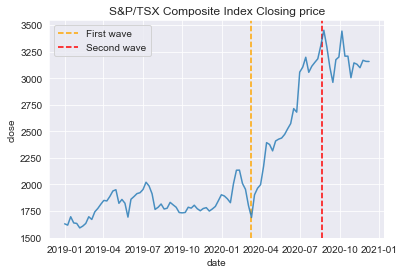

In [3]:
# load and merge the data
df = make_datasets.make_amazon_df()
# save the cleaned data
df.to_csv('../data/processed/sp_tsx.csv')

# plot dataframe
sns.set_style('darkgrid')
labels = ["First wave", "Second wave"]
plt.axvline(dt.datetime(2020, 3, 9), linestyle='dashed', color='orange')
plt.axvline(dt.datetime(2020, 8, 20), linestyle='dashed', color='red')
plt.legend(labels=labels)
sns.lineplot(x=df.index, y='close', data=df, alpha=0.8).set_title('S&P/TSX Composite Index Closing price')

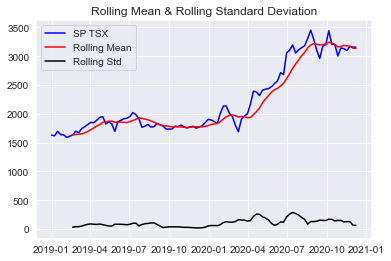

In [5]:
rolling_mean = df.rolling(window = 8).mean()
rolling_std = df.rolling(window = 8).std()
plt.plot(df, color = 'blue', label = 'SP TSX')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

<Figure size 432x288 with 0 Axes>

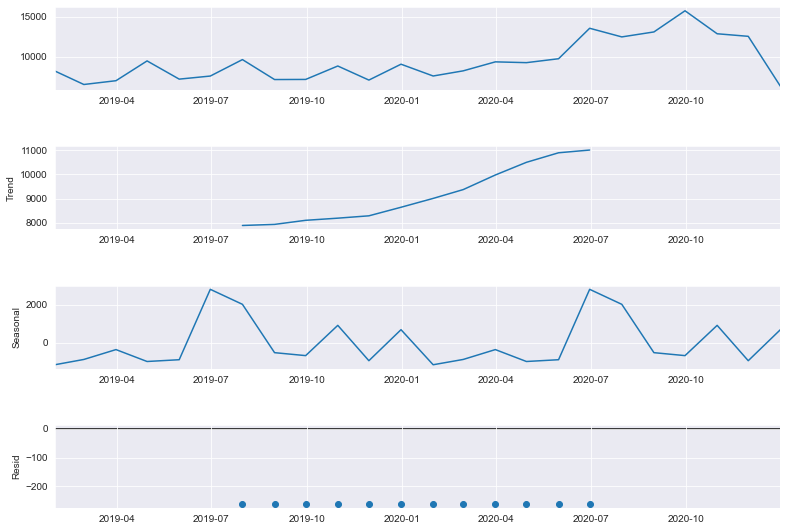

In [6]:
#get the season trend
decompose  = seasonal_decompose(df.resample('M').sum(),freq=12)
fig = plt.figure()
fig = decompose.plot()
fig.set_size_inches(12,8)

In [7]:
#Augmented Dickey-Fuller test in Python (ADF)

adf = adfuller(df['close'],12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -0.08627591059320125
p-value :  0.950788464678671
# n_lags :  3
No of observation:  98
 critical value 1% : -3.4989097606014496
 critical value 5% : -2.891516256916761
 critical value 10% : -2.5827604414827157


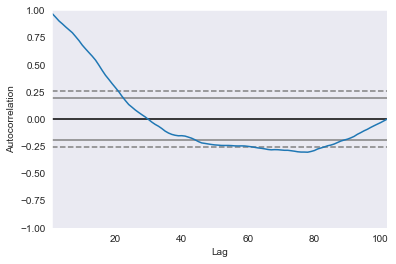

In [8]:
#autocorrelation plot

autocorrelation_plot(df['close'])
plt.show()

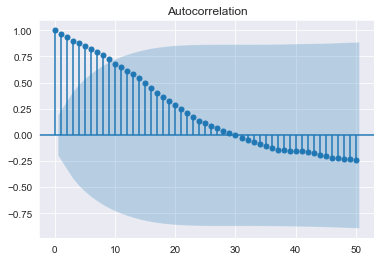

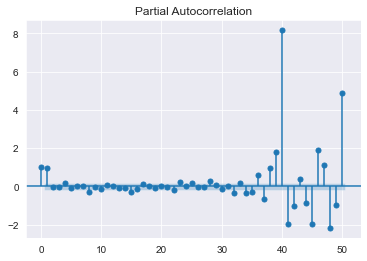

In [9]:
#allow us toe find the MA term (q), in this case we will go with 2 
plot_acf(df, lags=50)
#allow us to find the AR Term (p), in the case the, I'll have to try p= 1 or 2 
plot_pacf(df, lags=50)
plt.show()

In [10]:
#Find the best arima fit


smodel = pm.auto_arima(df.close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1212.517, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1212.551, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1214.548, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1214.548, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1213.028, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1213.395, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1213.193, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1216.072, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1216.153, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1211.718, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1213.662, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1213.033, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1211.026, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1211.694, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0]          

C:\Users\Yuri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  warnings.warn('No frequency information was'
C:\Users\Yuri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  warnings.warn('No frequency information was'


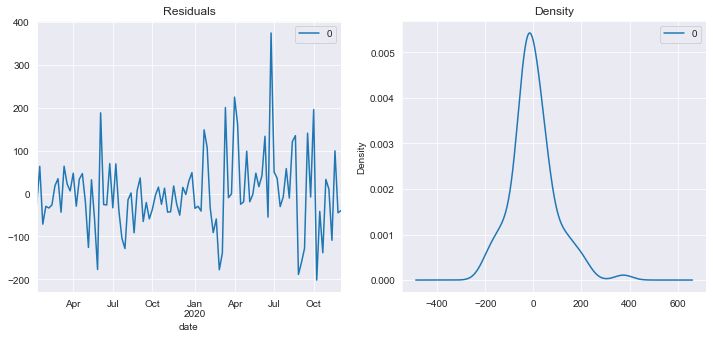

In [11]:
#plot residual errors 
"""
Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).
"""
model = ARIMA(df.close, order=(1,1,3))
model_fit = model.fit(disp=0)

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(12,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

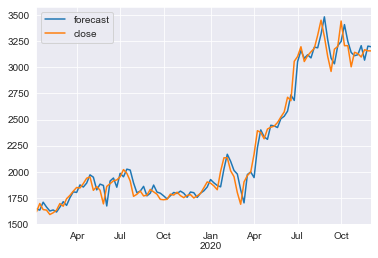

In [12]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [13]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.close[:57] #[:85]
test = df.close[57:] #[85:]

C:\Users\Yuri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  warnings.warn('No frequency information was'
C:\Users\Yuri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-TUE will be used.
  warnings.warn('No frequency information was'


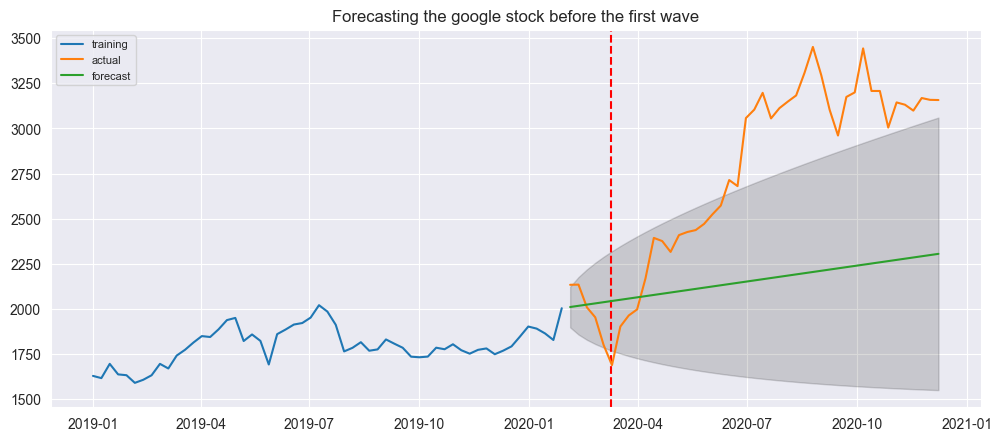

In [14]:
#We can now build our ARIMA model on training dataset, forecast and plot it. 

#Build Model 

#model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(0,1,0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(45, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.axvline(dt.datetime(2019, 1, 27), linestyle='dashed', color='orange')
plt.axvline(dt.datetime(2020, 3, 9), linestyle='dashed', color='red')
plt.legend(labels=labels)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecasting the google stock before the first wave')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
import numpy as np 
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

{'mape': 0.20982117598393762,
 'me': -578.3068624829457,
 'mae': 622.442295425654,
 'mpe': -0.18547055322989997,
 'rmse': 722.7810448147998,
 'acf1': 0.9397207166577195,
 'corr': 0.8912654488620327,
 'minmax': 0.2084370237602725}

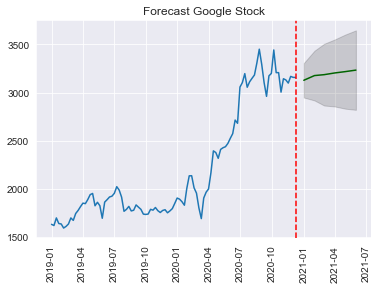

In [16]:
# Forecast
n_periods = 6
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
#2020-12-08
# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.axvline(dt.datetime(2020, 12, 8), linestyle='dashed', color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xticks(rotation=90)
plt.title("Forecast Google Stock")
plt.show()